In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Test of pipeline

## Step 1: Setup `Survey` parameters

### Galaxy properties

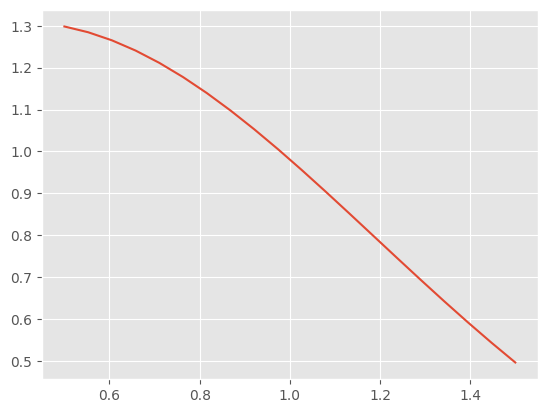

In [3]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

plt.plot(zs, pz)

### CIB Properties

In [4]:
nu_obs = [353, 545, 857] # Planck effective freq. in GHz

# load Planck filter response curves 
from galCIB.utils.io import load_my_filters

cib_filters = load_my_filters("/Users/tkarim/research/galCIB/data/filters/",
                nu_obs=nu_obs)

## Step 2: Setup `Survey`

In [5]:
from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
NSIDE = 1024 
#mag_alpha = 2.225 
mag_alpha = 1 #FIXME: turn on mag bias 

elg_survey = Survey(z=zs, 
                 pz=pz, mag_alpha=mag_alpha,  # galaxy-specific
                 cib_filters=cib_filters,  # dict: freq_GHz -> (freq_array_Hz, response_array)
                 ells=ells, nside=NSIDE,
                 name="DESI-Planck")

## Step 3: Setup `Cosmology`

In [6]:
ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(elg_survey.z, ks, Mh, colossus_cosmo_name='planck18',
                  use_little_h=False)

In [89]:
# optional save hmf and bias for DopperCIB test 

# np.save("/Users/tkarim/research/galCIB/tmp/hmf.npy",
#         cosmo.hmf_grid)

wmu = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


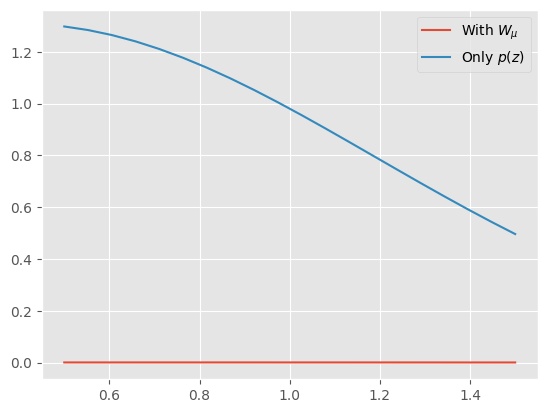

In [7]:
# Calculate window 

elg_survey.compute_windows(cosmo,True)
plt.plot(cosmo.z, elg_survey.Wg, label = r'With $W_{\mu}$')
plt.plot(zs, pz, label = r'Only $p(z)$')
plt.legend(loc='best')

## Step 4: Setup `HODModel` by using default model "DESI-ELG"

In [8]:
# Setup galaxy HOD

from galCIB import get_hod_model
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

## Step 5: Setup `SatProfile` 

Satellite galaxy profile in the $1$-halo term.

In [9]:
# Setup Satellite Profile Model 

from galCIB import SatProfile

#theta_sat = np.array([0.58, 6.14, 0.67])
theta_sat = np.array([0., 6.14, 1]) # no unfw
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


In [11]:
# optional save hmf and bias for DopperCIB test 

# np.save("/Users/tkarim/research/galCIB/tmp/bnu.npy",
#         elg_sat_profile.hbias)

## Step 6: Setup `CIBModel` and its submodule classes

### Step 6a: Setup `SFRModel` 

Using default SFR Model "M21" and applying the `HODModel` "Zheng05" on the IR-emitting galaxies. 

In [10]:
from galCIB import SFRModel

# IR-emitting galaxies  HOD model 
hod_IR = get_hod_model("Zheng05", cosmo)

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR, cosmo=cosmo,
                     fsub=0.134)

### Step 6b: Setup `SnuModel`

Using the default parametric "Y23" and the non-parametric "M21" models. 

In [11]:
from galCIB import SnuModel, CIBModel

#### Step 6bI : Setup "Y23" 

Test this model.

In [12]:
from galCIB import SnuModel

# Parametric Snu model (Y23)
snu_model_Y23 = SnuModel(name="Y23", cosmo=cosmo)

##### Combine at the level of `CIBModel` 

Calculate djc and djsub.

In [13]:
from galCIB import CIBModel 

# Initialize CIB model
cib_Y23 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_Y23,
                   hod_IR=hod_IR,
                   survey=elg_survey,
                   cosmo=cosmo
                   )

fsub = 0.134


In [14]:
# Parameters
theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.40, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [15]:
# Update cache
cib_Y23.update(theta_sfr, theta_snu, theta_IR)

# Access emissivities
djc = cib_Y23.get_djc()
djsub = cib_Y23.get_djsub()

(100, 20)
set Ncen_IR = 1 for testing.
(98, 100, 20)


#### Step 6bII : Setup "M21" 

Test this model.

In [46]:
# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21", cosmo=cosmo,
                         nu_prime=np.array([353, 545, 857]))

In [47]:
# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_M21,
                   hod_IR=hod_IR,
                   survey=elg_survey,
                   cosmo=cosmo
                   )

fsub = 0.134


## Step 7: Setup `PkBuilder` 

In [48]:
from galCIB import PkBuilder

In [49]:
# Y23 
pk_survey_Y23 = PkBuilder(cosmology=cosmo,
                      hod_model=elg_hod_model,
                      cib_model=cib_Y23,
                      prof_model=elg_sat_profile
                      )

# M21 
pk_survey_M21 = PkBuilder(cosmology=cosmo,
                      hod_model=elg_hod_model,
                      cib_model=cib_M21,
                      prof_model=elg_sat_profile
                      )

In [50]:
# parameters

# theta_cen = {}
# theta_sat = {}
# theta_prof = {}
theta_sfr = {}
theta_snu = {}
theta_IR  = {}

theta_cen = np.array([3.28, 11.49, 0.45, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.38, 10**11.14, 10**13., 0.59]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.52, 9.07, 0.7]) # fexp, tau, lambda_NFW
#theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

theta_sfr_M21 = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.52,-0.02, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_snu_M21 = None 
theta_IR_M21 = np.array([11.38, 2.6, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

theta_sfr_Y23 = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.4, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu_Y23 = np.array([2.7, 1.98,21.13, 0.21, 1.7]) # L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR_Y23 = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

theta_sfr['M21'] = theta_sfr_M21
theta_snu['M21'] = theta_snu_M21
theta_IR['M21'] = theta_IR_M21

theta_sfr['Y23'] = theta_sfr_Y23
theta_snu['Y23'] = theta_snu_Y23 
theta_IR['Y23'] = theta_IR_Y23

# theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
#                       11.78,0.40, #mu0_peak, mup_peak
#                       2.47,0.45,1.93]) #sigmaM0, tau, zc
# theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
# theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [51]:
# Pk predictions 
snu_models = ['M21', 'Y23']
pgg = {}
pII = {}
pgI = {}
pk_survey = {}
pk_survey['M21'] = pk_survey_M21
pk_survey['Y23'] = pk_survey_Y23

for snu in snu_models:
    print(snu)
    pgg[snu], pII[snu], pgI[snu] = pk_survey[snu].compute_pk(
        theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr[snu],
                     theta_snu=theta_snu[snu],
                     theta_IR_hod=theta_IR[snu],
                     hmalpha=1)

M21
(100, 20)
set Ncen_IR = 1 for testing.
(98, 100, 20)


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


Y23
(100, 20)
set Ncen_IR = 1 for testing.
(98, 100, 20)


: 

: 

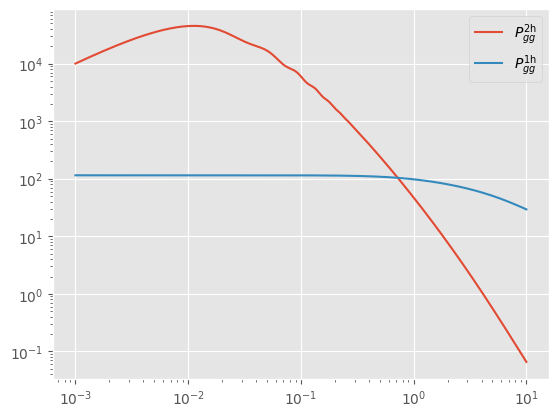

In [27]:
zidx = 5
plt.loglog(cosmo.k, 
           pk_survey['M21'].pk_gg_2h[:,zidx], 
           label = r'$P_{gg}^{\rm 2h}$')

plt.loglog(cosmo.k, 
           pk_survey['M21'].pk_gg_1h[:,zidx], 
           label = r'$P_{gg}^{\rm 1h}$')

plt.legend(loc='best')

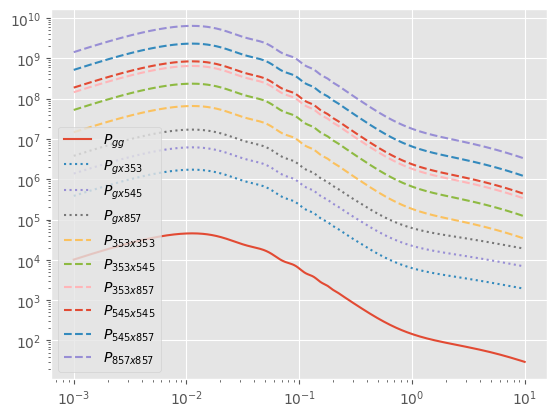

In [31]:
zidx = 5
plt.loglog(cosmo.k, pgg['M21'][:,zidx], 
           label = r'$P_{gg}$')

nulist = ['353', '545', '857']

for i in range(3):
    plt.loglog(cosmo.k, pgI['M21'][i,:,zidx],
               label = fr'$P_{{gx{nulist[i]}}}$',
               ls = 'dotted')
    
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    plt.loglog(cosmo.k, pII['M21'][i,:,zidx],
               label = fr'$P_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')

plt.legend(loc='best')

## Step 8: Compute $C (\ell)$ using `AnalysisModel`

In [32]:
from galCIB import AnalysisModel

In [33]:
analysis = {}

analysis['M21'] = AnalysisModel(cosmology=cosmo,
                         survey=elg_survey,
                         pk3d=pk_survey['M21'])

In [34]:
cgg, cgI, cII = analysis['M21'].update_cl(
    theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr['M21'],
                     theta_snu=theta_snu['M21'],
                     theta_IR_hod=theta_IR['M21'],
                     hmalpha=1)

(100, 20)
set Ncen_IR = 1 for testing.
(98, 100, 20)


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


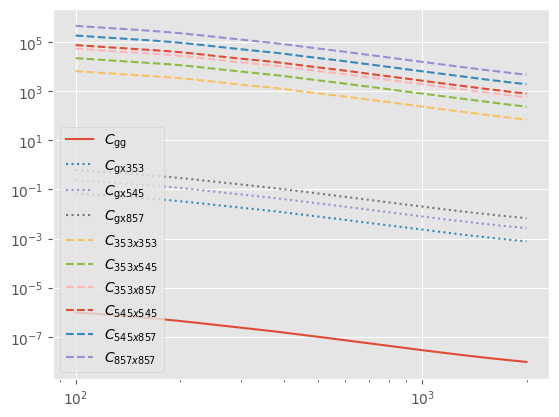

In [36]:
plt.loglog(elg_survey.ells, 
           cgg, label = r'$C_{\rm gg}$')

nulist = ['353', '545', '857']

for i in range(3):
    plt.loglog(elg_survey.ells, cgI[i,:],
               label = fr'$C_{{\rm gx{nulist[i]}}}$',
               ls = 'dotted')
    
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    plt.loglog(elg_survey.ells, cII[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')

plt.legend(loc='best')

##### Now try with `Y23`

# Compare with `DopplerCIB`

In [11]:
import sys 
sys.path.append("//Users/tkarim/research/DopplerCIB/")

import CIB_halo as mcib
import cosmo_related as mcosmo
import input_var_cibmean as minput
import Gal_halo as mgh
import CIBxGal_halo as mcg
import hmf_unfw_bias as mhmf_unfw

In [12]:
## initialize cosmo_var_iv and data_var_iv to pass to DopplerCIB

cosmo_var = mcosmo.cosmo_var_iv(mass=cosmo.Mh,
                                z=cosmo.z,
                                do_powerspec=1)

# experimental specification 

cib_exp = 'Planck'
# color corrections for 100, 143, 217, 353, 545, 857 and 3000 GHz for Planck
cc_pl = np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995])  # , 0.960])
cc = cc_pl  

nu0 = np.array([100., 143., 217., 353., 545., 857.]) 
nus = ['100', '143', '217', '353', '545', '857']
# fwhm obtained from https://wiki.cosmos.esa.int/planckpla/index.php/Effective_Beams
fwhm = np.array([9.651, 7.248, 4.990, 4.818, 4.682, 4.325])  # in arcmin
fwhm_rad = fwhm*(np.pi/180.)/60.
# fwhm = 4.8  # 4.8 Planck arcmin # 0.5 CCAT-Prime
# 1303.5067 for sensitivity (Tab:4 muK deg & kJy/sr deg)
sensitivity_muKarcmin = np.array([108., 48., 60., 210., 1137., 29075.])
sensitivity_Jy2_sr = np.array([58., 26.929, 72., 305, 369., 369.])
sensitivity_Jy_sr = np.sqrt(sensitivity_Jy2_sr)
# sensitivity = 13.5  # 13.5 Planck Jy/sr  # 1.2 CCAT-Prime
ell = np.logspace(2, np.log10(2000), 99)
fc = np.ones(len(nu0))

strfig = "allcomponents_lognormal_sigevol_1p5zcutoff_nolens_onlyautoshotpar_no3000_gaussian600n857n1200_planck_spire_hmflog10.txt"
cibres = "/Users/tkarim/research/galCIB/data/one_halo_bestfit_"+strfig

exp = {'name': cib_exp,
          'do_cibmean': 0,
          'cc': cc,
          'fc': fc,
          'snuaddr': '/Users/tkarim/research/galCIB/data/filtered_snu_planck.fits',
          # 'nu0min': nu0min, 'nu0max': nu0max,
          # 'nucen': str(int(nucen)),
          'nu0': nu0,
          'ell': ell,
          'fwhm': fwhm,
          'sensitivity': sensitivity_Jy_sr,
          'cibpar_resfile': cibres,
          'nu_string': nus}



Calculating the halo mass function for given mass and redshift for CIB mean calculations.


In [13]:
## initialize data_var_iv 
data_var_iv = minput.data_var_iv(exp = exp)

In [14]:
# initialize mcib_obj

mcib_obj = mcib.Cib_halo(data_var_iv,
                         cosmo_var)

In [15]:
from galCIB import SnuModel, SFRModel, CIBModel

In [16]:
theta_sfr_M21 = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.52,0, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR, cosmo=cosmo,
                     fsub=0.134)

# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21", cosmo=cosmo,
                         nu_prime=np.array([353, 545, 857]))

# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_M21,
                   hod_IR=hod_IR,
                   survey=elg_survey,
                   cosmo=cosmo,
                   Nm_sub=298)

fsub = 0.134


In [17]:
cib_M21.update(theta_sfr=theta_sfr_M21,
               theta_snu=None,
               theta_hod_IR=theta_IR)

(100, 20)
set Ncen_IR = 1 for testing.
(298, 100, 20)


In [18]:
# Comparison of Snu
(cib_M21._snu[2]/mcib_obj.snu[5]).sum()/len(cosmo.z)

0.999872620893273

In [19]:
# Comparison of SFR
(sfr_model(theta_sfr_M21)/mcib_obj.sfr(cosmo.Mh*(1-0.134))).sum()/mcib_obj.sfr(cosmo.Mh).size

(100, 20)


0.9977481105758318

In [20]:
# Comparison of djc
(mcib_obj.djc_dlnMh()[3:]/cib_M21.get_djc()).sum()/cib_M21.get_djc().size

0.134


1.0024045832055453

In [21]:
# Comparison of djsub
(mcib_obj.djsub_dlnMh()[3:]/cib_M21.get_djsub()).sum()/cib_M21.get_djsub().size

fsub = 0.134


1.0014813749919613

In [18]:
from galCIB import PkBuilder

# M21 
pk_survey_M21 = PkBuilder(cosmology=cosmo,
                      hod_model=elg_hod_model,
                      cib_model=cib_M21,
                      prof_model=elg_sat_profile
                      )

# compute pk

theta_cen = np.array([3.28, 11.49, 0.45, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.38, 10**11.14, 10**13., 0.59]) # As, M0, M1, alpha_sat
#theta_prof = np.array([0.52, 9.07, 0.7]) # fexp, tau, lambda_NFW
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

theta_sfr_M21 = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.52,0, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [19]:
# Pk predictions 
snu_models = ['M21']
pgg = {}
pII = {}
pgI = {}
pk_survey = {}
pk_survey['M21'] = pk_survey_M21

for snu in snu_models:
    print(snu)
    pgg[snu], pII[snu], pgI[snu] = pk_survey[snu].compute_pk(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     hmalpha=1)

M21
(100, 20)
set Ncen_IR = 1 for testing.


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


(298, 100, 20)


In [20]:
from galCIB import AnalysisModel

analysis = AnalysisModel(cosmology=cosmo,
                         survey=elg_survey,
                         pk3d=pk_survey['M21'])


In [21]:
cgg, cgI, cII = analysis.update_cl(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     hmalpha=1)

(100, 20)
set Ncen_IR = 1 for testing.
(298, 100, 20)


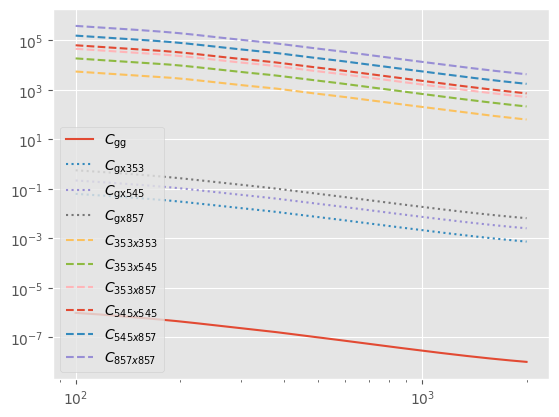

In [22]:
plt.loglog(elg_survey.ells, 
           cgg, label = r'$C_{\rm gg}$')

nulist = ['353', '545', '857']

for i in range(3):
    plt.loglog(elg_survey.ells, cgI[i,:],
               label = fr'$C_{{\rm gx{nulist[i]}}}$',
               ls = 'dotted')
    
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    plt.loglog(elg_survey.ells, cII[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')

plt.legend(loc='best')

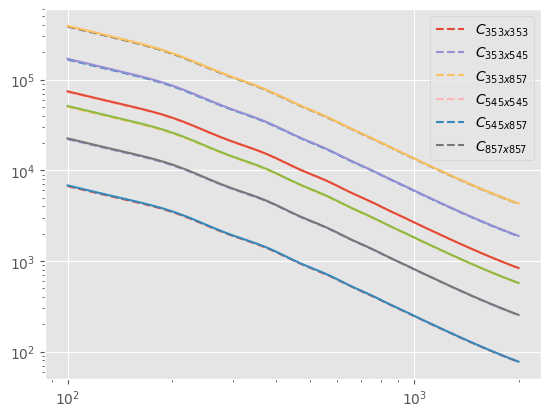

In [24]:
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    
    col_corr = mcib_obj.cc[a+3]*mcib_obj.cc[b+3]
    plt.loglog(elg_survey.ells, col_corr*cII[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')
    
    plt.loglog(mcib_obj.ell, 
           cl_m21[a+3,b+3])

plt.legend(loc='best')

Test $C_{gg}$

In [25]:
mgal_obj = mgh.ProfHODMore15(data_var_iv, cosmo_var,"DESI_ELG")

In [26]:
cgg_2h_m21 = mgal_obj.cl2h_gal()
cgg_m21 = mgal_obj.cl_galtot()

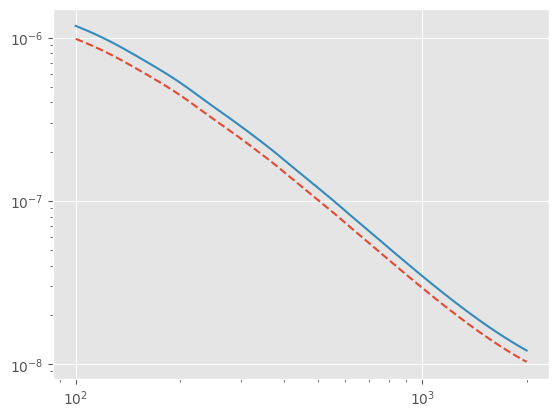

In [27]:
plt.loglog(elg_survey.ells, 
           cgg, ls = '--')

plt.loglog(mgal_obj.ell, 
           cgg_m21)

In [37]:
cgg_int = np.interp(mgal_obj.ell,
                    elg_survey.ells,
                    cgg)

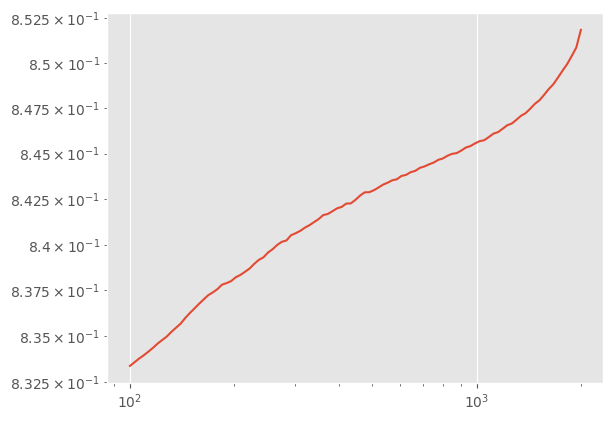

In [38]:
plt.loglog(mgal_obj.ell, 
           cgg_int/cgg_m21)

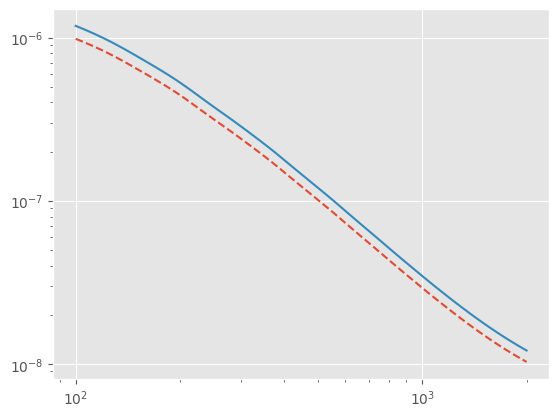

In [40]:
plt.loglog(mgal_obj.ell, 
           cgg_int,ls='--')

plt.loglog(mgal_obj.ell, 
           cgg_m21)


Test $C_{gI}$

In [42]:
mgI_obj = mcg.CIBxgal(data_var_iv,cosmo_var,
    "DESI_ELG",1)

In [45]:
mgI_obj.biasmz.shape

(100, 20)

In [50]:
cgI_m21 = mgI_obj.cibgalcross_cell_tot()[3:]

0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134


In [51]:
cgI_m21.shape

(3, 99)

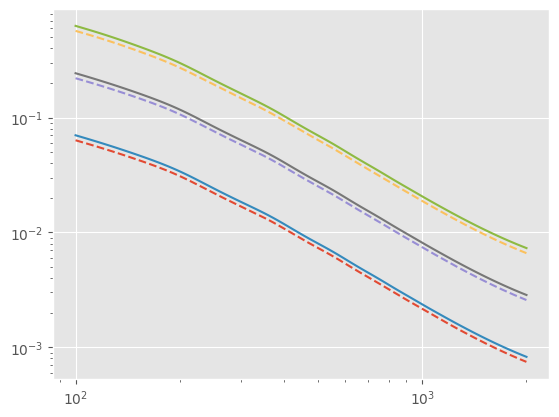

In [58]:
nidx = 0

for nidx in range(3):
    plt.loglog(elg_survey.ells,
            cgI[nidx],ls='--')
    plt.loglog(mgI_obj.ell, cgI_m21[nidx])

All combined

In [80]:
colors = ['blue', 'green', 'red']
# 353, 545, 857

# Get colormap
cmap = plt.get_cmap('winter')

# Choose values: 0.25 is bluish, 0.75 is greenish
bluish = cmap(0.25)
greenish = cmap(0.75)

cmap = plt.get_cmap('RdYlGn')
mid_color = cmap(0.5)  # This is a yellowish tone

# 353x545,353x857
colors_cross_II = [bluish,greenish,'brown']

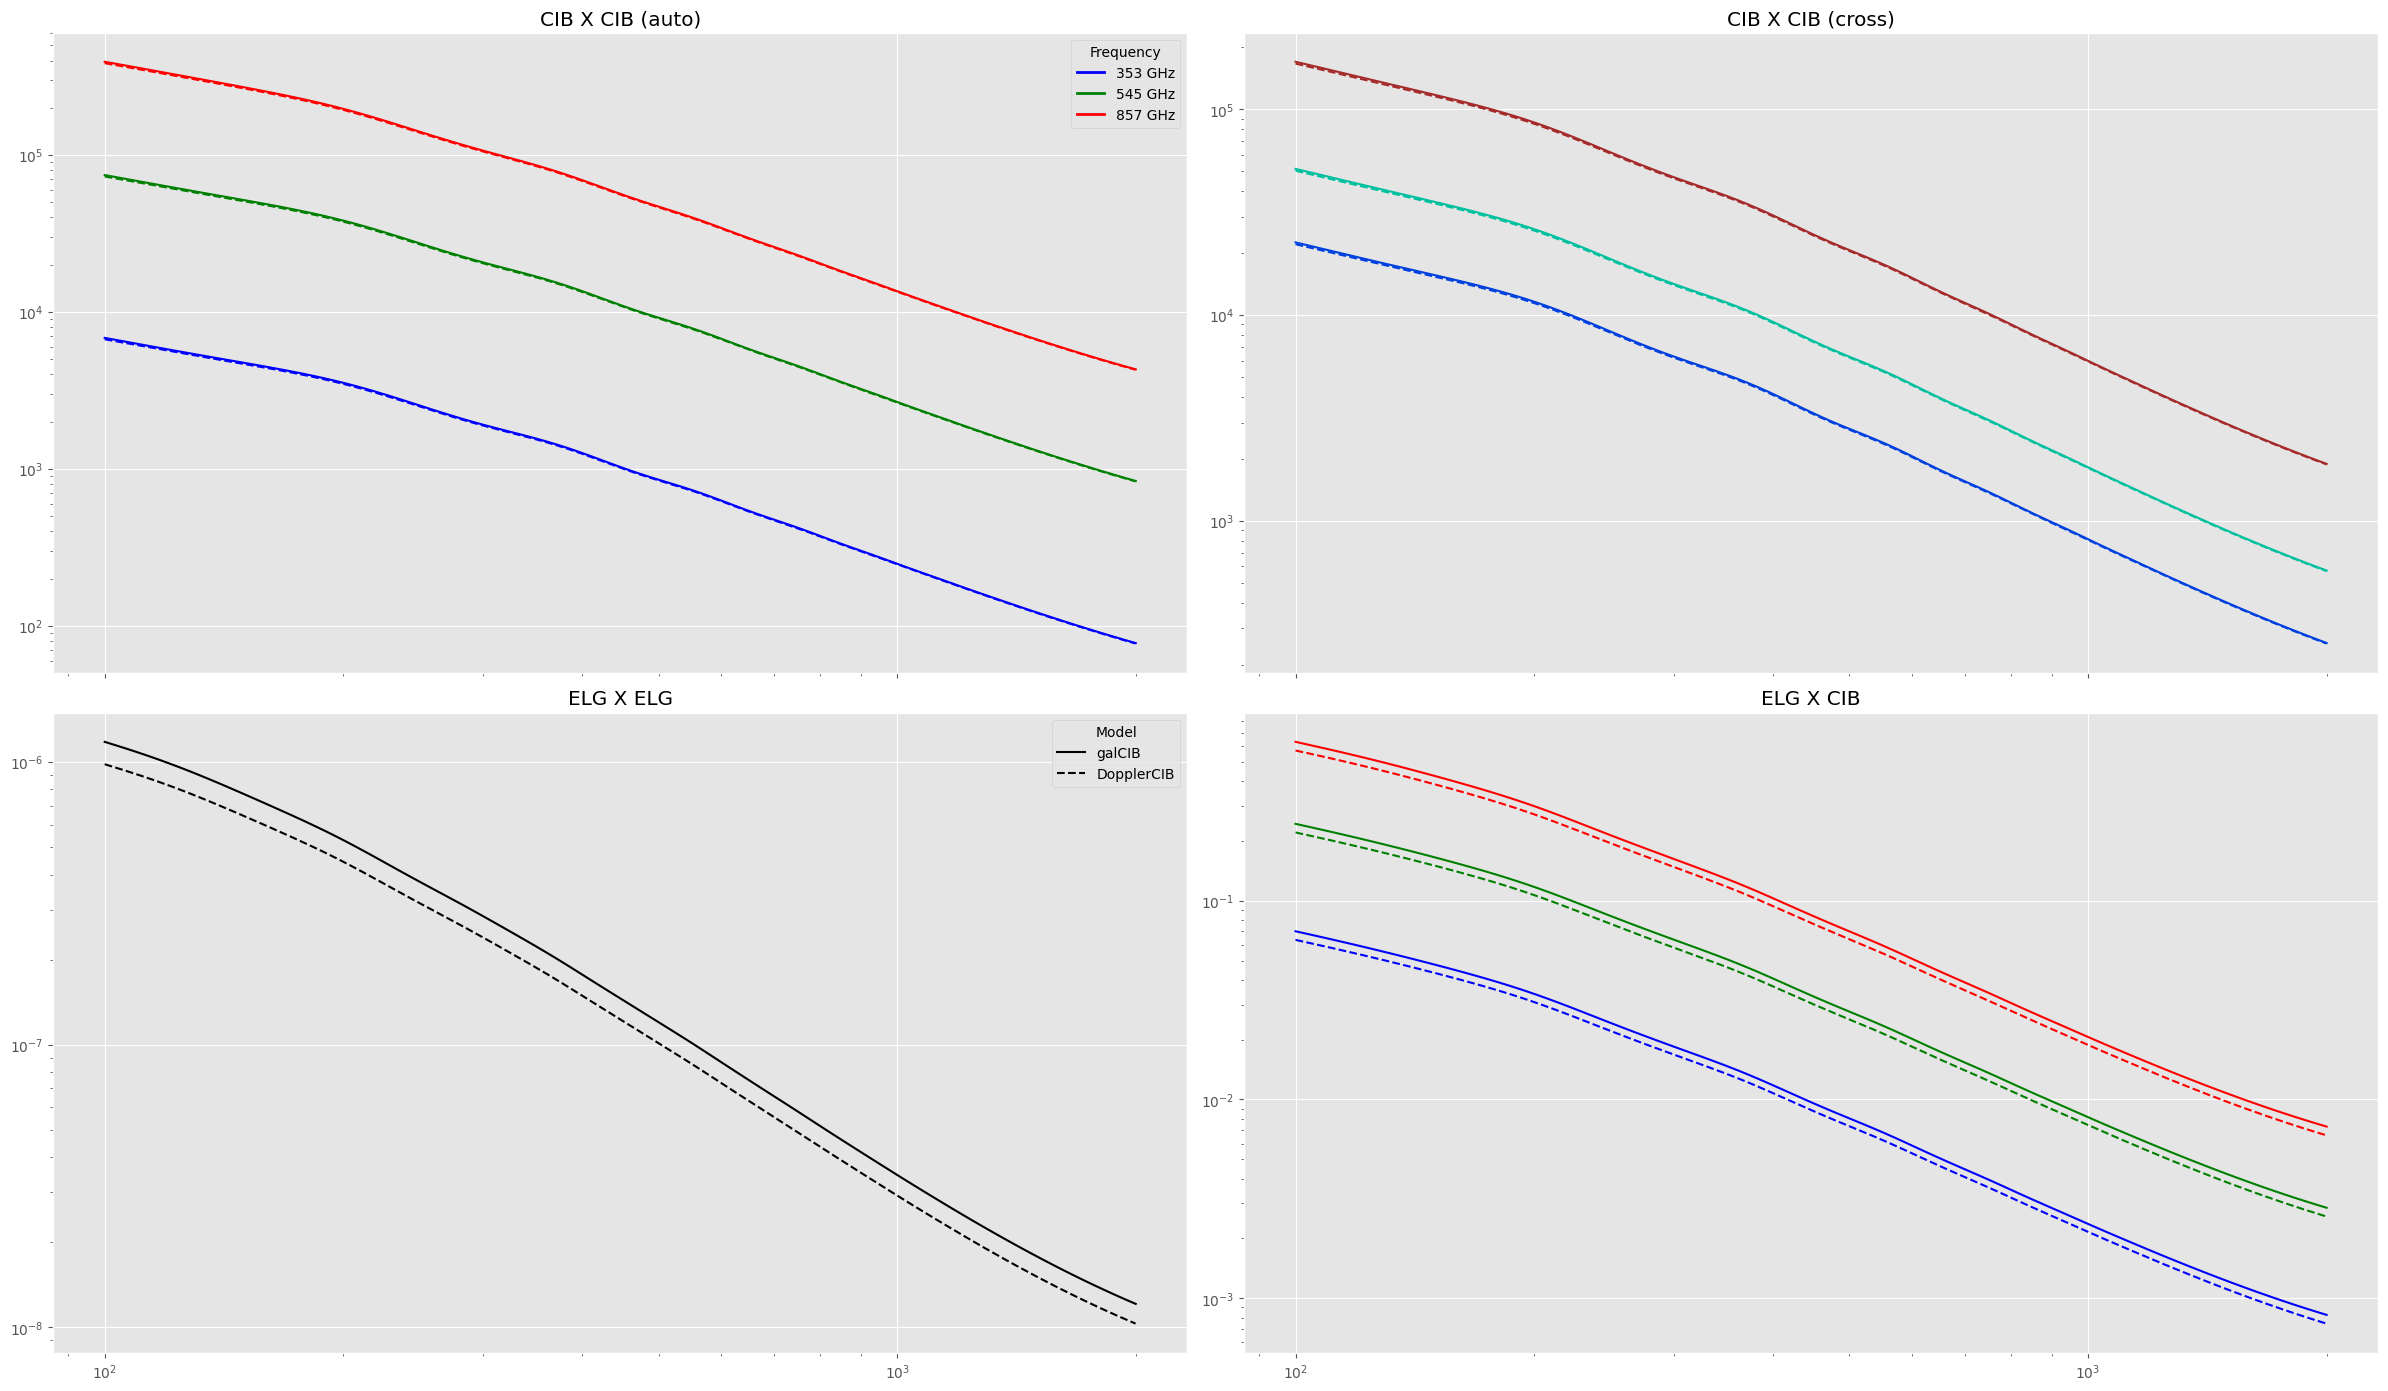

In [88]:
fig, axs = plt.subplots(2, 2, 
                        figsize=(25, 15),
                        sharex=True)

for nidx in range(3):
    axs[1,1].loglog(elg_survey.ells,
            cgI[nidx],ls='--',
            c=colors[nidx])
    axs[1,1].loglog(mgI_obj.ell, 
                    cgI_m21[nidx],
                    c=colors[nidx])
    
axs[1,0].loglog(elg_survey.ells,
                cgg,ls='--',
                c='k')
axs[1,0].loglog(mgal_obj.ell,
                cgg_m21,
                c='k')

for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    
    col_corr = mcib_obj.cc[a+3]*mcib_obj.cc[b+3]
    
    if a == b:
        axs[0,0].loglog(elg_survey.ells, 
                col_corr*cII[i,:],
                #label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
                ls = 'dashed',
                c=colors[a])
    
        axs[0,0].loglog(mcib_obj.ell, 
                cl_m21[a+3,b+3],
                c=colors[a])
    else:
        axs[0,1].loglog(elg_survey.ells, 
        col_corr*cII[i,:],
        #label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
        ls = 'dashed',
        c=colors_cross_II[a+b-1])
        
        axs[0,1].loglog(mcib_obj.ell, 
        cl_m21[a+3,b+3],
        c=colors_cross_II[a+b-1])
        
axs[0,0].set_title("CIB X CIB (auto)")
axs[0,1].set_title("CIB X CIB (cross)")
axs[1,0].set_title("ELG X ELG")
axs[1,1].set_title("ELG X CIB")


from matplotlib.lines import Line2D
# Legend 1: Line style = model
model_legend = [
    Line2D([0], [0], color='black', linestyle='-', label='galCIB'),
    Line2D([0], [0], color='black', linestyle='--', label='DopplerCIB')
]

# Legend 2: Color = frequency
freq_legend = [
    Line2D([0], [0], color='blue', lw=2, label='353 GHz'),
    Line2D([0], [0], color='green', lw=2, label='545 GHz'),
    Line2D([0], [0], color='red', lw=2, label='857 GHz')
]

# --------------- Add the legends anywhere ---------------

# Example: Add model legend to upper left subplot (axs[0,0])
axs[1,0].legend(handles=model_legend, title='Model', loc='upper right')

# Example: Add frequency legend to lower right subplot (axs[1,1])
axs[0,0].legend(handles=freq_legend, title='Frequency', loc='upper right')

plt.tight_layout()

fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)

plt.savefig("../figures/compare-dopplercib-galcib.pdf",
            bbox_inches='tight', dpi=300)

# Issues: 
- ~~Calculate $k$ for given $\ell$ per $z$, and re sample $P(k)$.~~ 
- ~~Integrate over the same $\ell$-to-$k$ grid~~
- ~~SFR Model test~~
- ~~SFR Model registry setup~~
- $S_{\nu}$ Model test
    - M21
    - ~~Y23~~
- $S_{\nu}$ Model registry setup 
    - M21
    - ~~Y23~~
- ~~$S_{\nu}$ filter turn-on option and utils to convolve with Planck filter~~
- $\theta$ update method in `AnalysisModel`
- Write submodule on MCMC and setup `loglikelihood` method 
- Run MCMC with just $C_{\rm gg}$
- $P_{\rm CIB-CIB}$ and $P_{\rm g-CIB}$
- Refactor `pk.py`; compute.py to contain all the Pk functions? 
- Include color correction in `AnalysisModel`
- Include `Survey`-specific $\ell$ binning in `AnalysisModel`.